In [99]:
import numpy as np
import matplotlib.pylab as plt

**Calculate a Kitaev chain's transport properties**

In [100]:
# Parameter settings
N = 10
mu = 0.0
t = 1.1
delta = 0.9
epsilon = 0
#
t_lead_c = 20              #
eta = 1e-5j

In [101]:
def build_kitaev_chain(N, mu, t, delta):
    """
    构建 Kitaev 链的 BdG 哈密顿量，返回 2N x 2N Hermitian 矩阵
    N: 链的格点数
    mu: 化学势
    t: 跃迁能
    delta: 超导配对能
    """
    H = np.zeros((2*N, 2*N), dtype=complex)

    for i in range(N):
        # 化学势项
        H[i, i] = -mu
        H[i+N, i+N] = mu  # 对应于空穴

        if i < N - 1:
            # 跃迁项：c_i^\dagger c_{i+1}
            H[i, i+1] = -t
            H[i+1, i] = -t

            H[i+N, i+1+N] = t
            H[i+1+N, i+N] = t

            # 超导配对项：Δ c_i c_{i+1}
            H[i, i+1+N] = delta
            H[i+1, i+N] = -delta

            H[i+1+N, i] = delta
            H[i+N, i+1] = -delta

    return H

In [102]:
#能量范围
Erange = 0.1
lenE = 1000001
Esample = np.linspace(-Erange, Erange, lenE)
DOS = np.zeros(lenE)

In [103]:
Hc = build_kitaev_chain(N, mu, t, delta)

In [104]:
def compute_transport_quantities(Hc, t_lead_c, Nx, epsilon, lenE):
    H_c = Hc
    N_bdg = 2*Nx  # BdG表象下的维度
    
    # 电极耦合矩阵（扩展到Nambu空间）
    H0c = np.zeros((1, Nx), dtype=complex)  # 对应Nambu空间中的电子和空穴
    H0c[0, 0] = t_lead_c          # 电子耦合
    #H0c[1, Nx] = -np.conj(t_lead_c)  # 空穴耦合
    
    H1c = np.zeros((1, Nx), dtype=complex)
    H1c[0, Nx-1] = t_lead_c
    #H1c[1, 2*Nx-1] = -np.conj(t_lead_c)
    
    # 电极哈密顿量（扩展到Nambu空间）
    H00 = np.array([[epsilon]], dtype=complex)
    H01 = np.array([[t]], dtype=complex)
    #H00[0,0] = epsilon    # 电子部分
    #H00[1,1] = -np.conj(epsilon)  # 空穴部分
    
    #H01 = np.zeros((2,2), dtype=complex)
    #H01[0,0] = t
    #H01[1,1] = -np.conj(t)

    DOS        = np.zeros(lenE)
    tun01      = np.zeros(lenE)
    Shot_noise = np.zeros(lenE)

    for iE, E in enumerate(Esample):
        # 左电极自能计算（递归格林函数方法）
        ai = H01.copy(); bi = H01.T.copy()
        ei = H00.copy(); eg = H00.copy()
        for _ in range(60):
            mm = np.linalg.inv((E + eta) * np.eye(1) - ei)
            eg += ai @ mm @ bi
            ei += ai @ mm @ bi + bi @ mm @ ai
            ai = ai @ mm @ ai
            bi = bi @ mm @ bi
        grL = np.linalg.inv((E + eta) * np.eye(1) - eg)
        ss0 = H0c.T @ grL @ H0c
        Gamma0 = 1j * (ss0 - ss0.conj().T)
        Gamma0_Bdg =  np.block([
    [Gamma0,                np.zeros_like(Gamma0)],
    [np.zeros_like(Gamma0), Gamma0.T]
])
        # 右电极自能计算
        ai = H01.T.copy(); bi = H01.copy()
        ei = H00.copy(); eg = H00.copy()
        for _ in range(60):
            mm = np.linalg.inv((E + eta) * np.eye(1) - ei)
            eg += ai @ mm @ bi
            ei += ai @ mm @ bi + bi @ mm @ ai
            ai = ai @ mm @ ai
            bi = bi @ mm @ bi
        grR = np.linalg.inv((E + eta) * np.eye(1) - eg)
        ss1 = H1c.T @ grR @ H1c
        Gamma1 = 1j * (ss1 - ss1.conj().T)
        Gamma1_Bdg =  np.block([
    [Gamma1,                np.zeros_like(Gamma1)],
    [np.zeros_like(Gamma1), Gamma1.T]
])
        # 中心格林函数
        gr = np.linalg.inv((E + eta) * np.eye(N_bdg) - H_c + (1j/2)*(Gamma1_Bdg + Gamma0_Bdg))
        rho = -1/np.pi * np.imag(np.diag(gr))
        DOS[iE] = np.sum(rho)

        # 透射系数（主要考虑电子-电子通道）
        T01matrix = Gamma0_Bdg @ gr @ Gamma1_Bdg @ gr.conj().T
        T01 = np.real(np.trace(T01matrix[:Nx, :Nx]))
        #T01 = np.real(np.trace(T01matrix))
        tun01[iE] = T01
        
        if np.abs(T01) > 1e-12:
            #Shot_noise[iE] = (1 - T01) * T01
            Shot_noise[iE] = np.real(np.trace(T01matrix[:Nx, :Nx] @ T01matrix[:Nx, :Nx]))
            

    return DOS, tun01, Shot_noise

In [105]:
#t_lead_c_list = [0.1, 0.3, 0.5, 0.8]
t_lead_c_list = [0.1]
results = {}
for tc in t_lead_c_list:
    DOS, T, Noise = compute_transport_quantities(Hc, tc, N, epsilon=0, lenE = lenE)
    results[tc] = {'DOS': DOS, 'T': T, 'Noise': Noise}

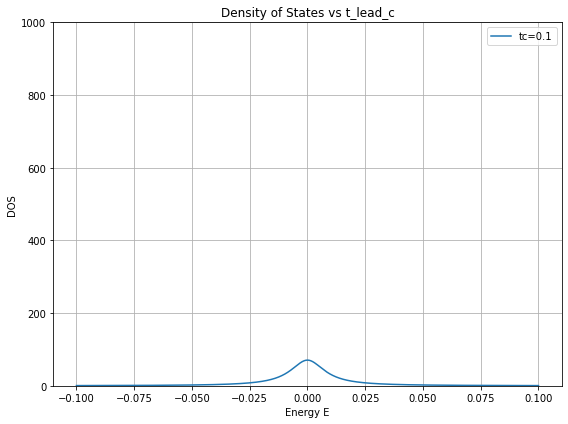

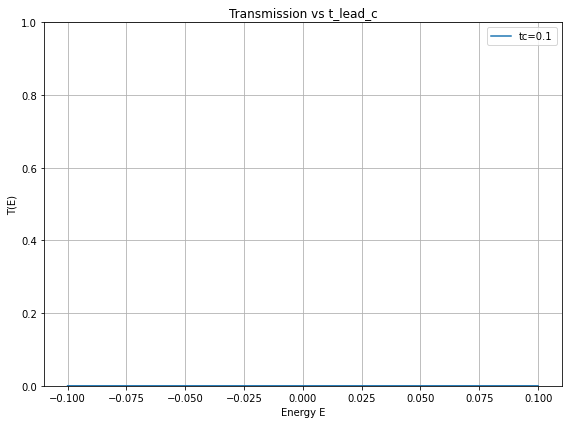

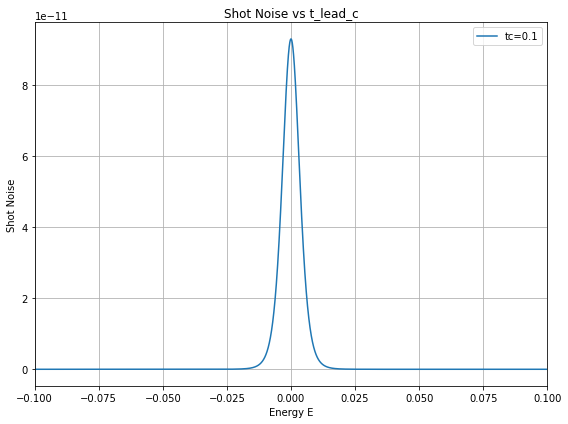

In [106]:
# DOS图
plt.figure(figsize=(8, 6))
for tc in t_lead_c_list:
    plt.plot(Esample, results[tc]['DOS'], label=f'tc={tc}')
plt.xlabel('Energy E')
plt.ylabel('DOS')
plt.title('Density of States vs t_lead_c')
plt.legend()
plt.grid(True)
#plt.xlim(-0.1, 0.1)
plt.ylim(0, 1000)
plt.tight_layout()
plt.show()

# Transmission图
plt.figure(figsize=(8, 6))
for tc in t_lead_c_list[0:]:
    plt.plot(Esample, results[tc]['T'], label=f'tc={tc}')
plt.xlabel('Energy E')
plt.ylabel('T(E)')
plt.title('Transmission vs t_lead_c')
plt.legend()
plt.grid(True)
#plt.xlim(-0.1, 0.1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Shot Noise图
plt.figure(figsize=(8, 6))
for tc in t_lead_c_list:
    plt.plot(Esample, results[tc]['Noise'], label=f'tc={tc}')
plt.xlabel('Energy E')
plt.ylabel('Shot Noise')
plt.title('Shot Noise vs t_lead_c')
plt.legend()
plt.grid(True)

plt.xlim(-0.1, 0.1)
plt.tight_layout()
plt.show()